## Семинар 6 "Segmentation"

ФИО: Токаева Александра Александровна

## Задание

Предлагается поучаствовать в конкурсе https://drive.grand-challenge.org/

Для зачета требуется получить значение dice-coefficient на leaderboard не меньше 0.8 и прислать ноутбук с кодом и кратким отчетом: что пробовали, что сделали, мысли почему окончательная архитектура лучше остальных.

Называйте своего юзера с суффиксом [sphere].

Также первые 3 человека получат бонусные 6, 4, 2 балл соответственно. (deadline: 23:59 14 ноября 2021). Скорее всего будут дополнительные плюшки для призеров конкурса.


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch as t
from torch.utils import data
import torch.nn.functional as F
from torchvision import transforms as tsf
import scipy.misc
import torch.nn as nn
from pathlib import Path
#from pytorch_lightning import Trainer
#from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from torch.nn import MSELoss
import torch

from PIL import Image
import skimage
from skimage import io


#from torch.utils.tensorboard import SummaryWriter

TRAIN_PATH = './train.pth'
TEST_PATH = './test.pth'
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [4]:
def process(dataset_path, mask_path=None, filter_path=None):
    data = []
    if mask_path:
        mask_path = Path(mask_path)
        
    if filter_path:
        filter_path = Path(filter_path)

    for image in sorted(Path(dataset_path).iterdir()):
        item = {}
        img = io.imread(image)
        
        if img.shape[2]>3:
            assert(img[:,:,3]!=255).sum()==0
        
        img = img[:,:,:3]
        item['name'] = image.name.split("_")[0]
        item['img'] = t.from_numpy(img)
        if mask_path:
            mask = io.imread(mask_path/(item['name'] + "_manual1.gif"))
            item['mask'] = t.from_numpy(mask)
            
        if filter_path:
            filter_elem = io.imread(filter_path/(item['name'] + '_training_mask.gif'))
            item['filter'] = t.from_numpy(filter_elem)
        data.append(item)
    
    return data
test = process('test/images/')
t.save(test, TEST_PATH)
train_data = process('train/images', "train/1st_manual/", 'train/mask/')

In [60]:
import PIL
class Dataset():
    def __init__(self,data,source_transform,target_transform, filter_transform):
        self.datas = data
        self.s_transform = source_transform
        self.t_transform = target_transform
        self.f_transform = filter_transform
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        mask = data['mask'][:,:,None].byte().numpy()
        filt = data['filter'][:,:,None].byte().numpy()
        img = self.s_transform(img)
        mask = self.t_transform(mask)
        filt = self.f_transform(filt)
        return img, mask, filt
    def __len__(self):
        return len(self.datas)
s_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((565,584)),
    tsf.ToTensor(),
    tsf.ColorJitter(brightness=(1.5,1.5)),
    tsf.Normalize(mean = [0.5,0.5,0.5],std = [0.5,0.5,0.5])
]
)
t_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((565,584),interpolation=PIL.Image.NEAREST),
    tsf.ToTensor(),]
)
f_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((565,584)),
    tsf.ToTensor()
])
train_dataset = Dataset(train_data,s_trans,t_trans,f_trans)
#dataloader = t.utils.data.DataLoader(dataset,num_workers=2,batch_size=4)

print(train_dataset[0][0].shape)
print(train_dataset[0][1].shape)

torch.Size([3, 565, 584])
torch.Size([1, 565, 584])


In [61]:
class TestDataset():
    def __init__(self,path,source_transform):
        self.datas = t.load(path)
        self.s_transform = source_transform
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        img = self.s_transform(img)
        return img
    def __len__(self):
        return len(self.datas)

test_dataset = TestDataset(TEST_PATH, s_trans)
testdataloader = t.utils.data.DataLoader(test_dataset,batch_size=1)

In [62]:
test_dataset[0].shape

torch.Size([3, 565, 584])

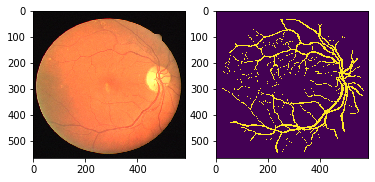

In [63]:
img,mask,filt = train_dataset[4]
plt.subplot(121)
plt.imshow(img.permute(1,2,0).numpy()*0.5+0.5)
plt.subplot(122)
plt.imshow(mask[0].numpy())

In [64]:
class double_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up, self).__init__()
        self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)
        self.conv = double_conv(in_ch, out_ch) 

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))

        x = t.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x



class UNet(nn.Module):
    def __init__(self, n_channels, n_classes=0):
        super(UNet, self).__init__()
        self.inc = double_conv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        x = F.sigmoid(x)
        return x

torch.Size([1, 128, 128])


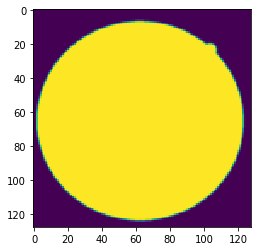

In [65]:
from torchvision import transforms
from PIL import Image
p = transforms.Compose([transforms.Scale((128, 128)), tsf.ToTensor()])
m=p(Image.open("train/mask/21_training_mask.gif"))
print(m.shape)
plt.imshow(m[0])

In [66]:
# Попробуйте использовать различные функции потерь.
#from torchvision import transforms
#from PIL import Image
#p = transforms.Compose([transforms.Scale((128, 128)), tsf.ToTensor()])
#m=p(Image.open("train/mask/21_training_mask.gif"))
#m=m[0]

def soft_dice_loss(inputs, targets, filters):
    m1 = inputs * filters
    m2 = targets * filters
    intersection = (m1 * m2)
    score = (2. * intersection.sum() + 1) / (m1.sum() + m2.sum() + 1)
    return 1 - score

In [67]:
from tqdm import tqdm
def train(network, epochs, learning_rate):
    loss = soft_dice_loss
    #loss=MSELoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in tqdm(range(epochs)):
            losses = []
            accuracies = []
            for X, y, f in train_dataset:
                X=X.reshape(-1,3,565,584)
                network.zero_grad()
                prediction = network(X)
                y=y[0]
                prediction=prediction[0][0]
                #print(y.shape) 
                #print(prediction.shape)
                loss_batch = loss(prediction, y, f[0])
                #print("train_loss=",loss_batch)
                losses.append(loss_batch.item())
                loss_batch.backward()
                optimizer.step()
                #accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            train_loss_epochs.append(np.mean(losses))
            #train_accuracy_epochs.append(np.mean(accuracies))
            
            
            print('\rEpoch {0}... (Train/Test) MSE: {1:.3f}/{2:.3f}'.format(
                        epoch, train_loss_epochs[-1], train_loss_epochs[-1]))
            
            
            plt.figure(figsize=(12, 5))
            #plt.subplot(1, 1, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        pass

In [69]:
NET=UNet(n_channels=3)
%time train(NET, 100, 0.001)

  0%|          | 0/5 [03:45<?, ?it/s]

CPU times: user 3min 18s, sys: 25.7 s, total: 3min 43s
Wall time: 3min 45s


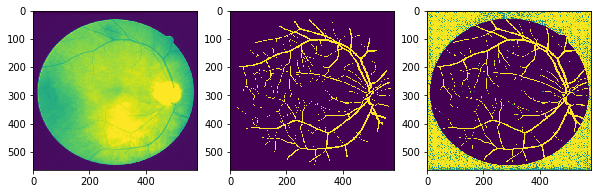

In [22]:
plt.figure(figsize=(10,10))
ax1=plt.subplot(1,3,1)
ax1.imshow(train_dataset[12][0].detach().numpy()[0])
ax2=plt.subplot(1,3,2)
ax2.imshow(train_dataset[12][1].detach().numpy()[0])
ax3=plt.subplot(1,3,3)
otv=NET(train_dataset[12][0].reshape(-1,3,565,584))
ax3.imshow(otv[0].detach().numpy()[0])

In [23]:
#os.makedirs("result")

import imageio
model = NET.eval()
for ex_id, data in enumerate(testdataloader):
    data = t.autograd.Variable(data, volatile=True)
    o = model(data)
    
    source_image = io.imread("test/images/%s_test.tif" % str(ex_id + 1).zfill(2))
    tm = o[0][0].data.cpu().numpy()
    tm = skimage.transform.resize(tm, source_image.shape[:-1])
    tm = (tm > 0.5).astype('uint8')*255
    
    imageio.imwrite("result/%s.png" % (ex_id + 1), tm)
    #scipy.misc.imsave("test/result/%s.png" % (ex_id + 1), tm)
    
!zip -r result.zip result

"zip" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


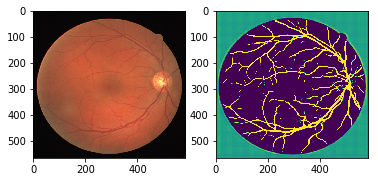

In [44]:
tm=o[0][0].data.cpu().numpy()
plt.subplot(121)
plt.imshow(data[0].data.cpu().permute(1,2,0).numpy()*0.5+0.5)
plt.subplot(122)
plt.imshow(tm)